In [1]:
from troughfinder import void_model as VM

#### We test against the CBL implementation

In [2]:
import CosmoBolognaLib as cbl

#### Other imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [4]:
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 7

mpl.rcParams['font.size'] = 20

mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['ytick.minor.size'] = 5

mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2


mpl.rcParams['axes.xmargin'] = mpl.rcParamsDefault['axes.xmargin']

# Tests
troughfinder uses the same code as CBL ported in python with the CCL librairy to handle the cosmology part.    
WARNING: CBL uses units with $h^{-1}$ while CCL (and troughfinder) does not ! We take this into account when we make the comparison.

### Set cosmology

In [5]:
cosmo = {
    "Om": 0.25,
    "sigma8": 0.8,
    "ns": 0.95,
    "Ob": 0.044,
    "Olambda": 0.75,
    "h": 0.702,
    "Omn": 0,
    "Omr": 0,
    "massless": 3.04,
    "massive": 0,
    "w0": -1,
    "w1": 0,
    "fNL": 0,
    "type_NG":1,
    "tau": 0.087,
    "model": "LCDM",
}

#### Initialize CBL

In [6]:
cosmo_cbl = cbl.Cosmology()
cosmo_cbl.set_model(cosmo["model"])
cosmo_cbl.set_OmegaM(cosmo["Om"])
cosmo_cbl.set_OmegaB(cosmo["Ob"])
cosmo_cbl.set_OmegaNu(cosmo["Omn"])
cosmo_cbl.set_OmegaDE(cosmo["Olambda"])
cosmo_cbl.set_Omega_radiation(cosmo["Omr"])
cosmo_cbl.set_hh(cosmo["h"])
cosmo_cbl.set_sigma8(cosmo["sigma8"])
cosmo_cbl.set_n_spec(cosmo["ns"])
cosmo_cbl.set_w0(cosmo["w0"])
cosmo_cbl.set_wa(cosmo["w1"])
cosmo_cbl.set_fNL(cosmo["fNL"])
cosmo_cbl.set_type_NG(cosmo["type_NG"])
cosmo_cbl.set_tau(cosmo["tau"])
cosmo_cbl.set_unit(True)


CBL > Warning in the CBL function set_hh of Cosmology.h: if unit=true then H0=100 (by internal definition)



#### Initialize troughfinder

In [7]:
tf_model = VM.CosmicVoidModel(
    Omega_m=cosmo['Om'],
    Omega_b=cosmo['Ob'],
    h=cosmo['h'],
    n_s=cosmo['ns'],
    sigma8=cosmo['sigma8'],
    Omega_k=0,
    transfer_function='eisenstein_hu',
    matter_power_spectrum='halofit',
)

### Test values

In [8]:
z = 0.1
a = 1/(1+z)
Rmpc = np.logspace(-2, np.log10(50), 500)        # Distance in Mpc
Rmpch = Rmpc*cosmo["h"]                          # Distance in Mpc/h
b_eff = 1.2

# Both code has default values for those parameters but we set them manually to be sure
slope = 0.854
offset = 0.420
del_v = -0.8
del_c = 1.686

## Compare $\sigma^{2}(R)$
This is where both code differ the most.

#### CBL

In [9]:
cbl_sig2 = np.array([cosmo_cbl.sigma2R(R_tmp, "EisensteinHu", z) for R_tmp in Rmpch])

#### troughfinder

In [10]:
tf_sig2 = tf_model._sigma2R(Rmpc, z)

#### Compare

Text(0, 0.5, 'Error (in %)')

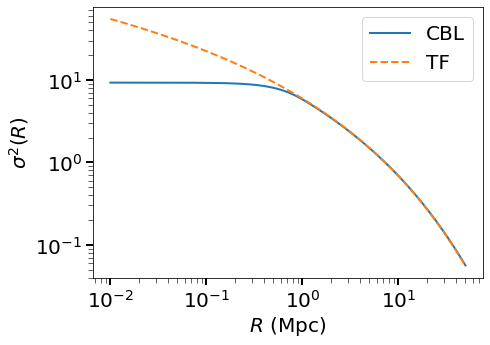

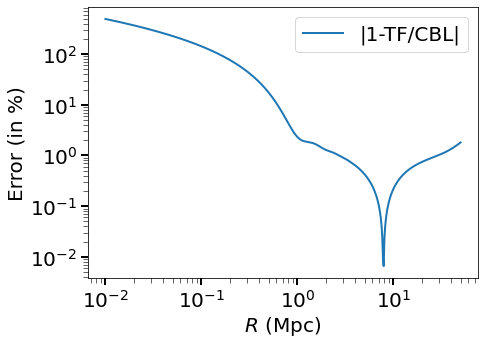

In [11]:
plt.figure(figsize=(7,5))
plt.plot(Rmpc, cbl_sig2, label="CBL")
plt.plot(Rmpc, tf_sig2, '--', label="TF")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.xlabel("$R$ (Mpc)")
plt.ylabel("$\sigma^{2}(R)$")

plt.figure(figsize=(7,5))
plt.plot(Rmpc, np.abs(1-tf_sig2/cbl_sig2)*100, label="|1-TF/CBL|")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.xlabel("$R$ (Mpc)")
plt.ylabel("Error (in %)")

## Compare $\frac{d\sigma^{2}(R)}{dR}$
We also need the first derivative of $\sigma^{2}(R)$ with respect to $R$.    
In troughfinder we use `scipy.misc.derivative` to compute it. CBL use an analytic form.

#### CBL

In [12]:
cbl_sig2deriv = np.array([cosmo_cbl.dnsigma2R(1, R_tmp, "EisensteinHu", 0) for R_tmp in Rmpch])*cosmo["h"]

#### troughfinder

In [13]:
tf_sig2deriv = tf_model._d1sigma2R(Rmpc)

Text(0, 0.5, 'Error (in %)')

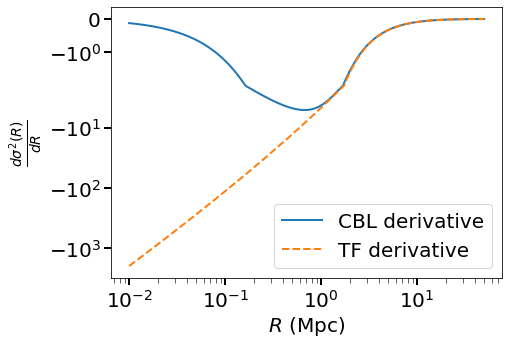

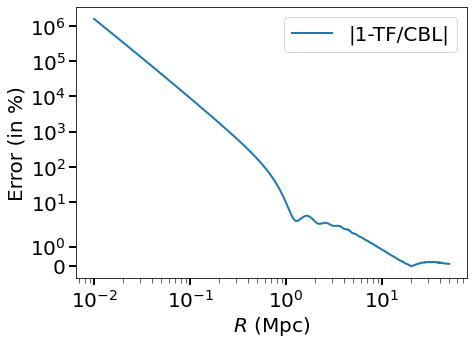

In [14]:
plt.figure(figsize=(7,5))
plt.plot(Rmpc, cbl_sig2deriv, label="CBL derivative")
plt.plot(Rmpc, tf_sig2deriv, '--', label="TF derivative")
plt.yscale("symlog")
plt.xscale("log")
plt.legend()
plt.xlabel("$R$ (Mpc)")
plt.ylabel(r"$\frac{d\sigma^{2}(R)}{dR}$")

plt.figure(figsize=(7,5))
plt.plot(Rmpc, np.abs(1-(tf_sig2deriv)/cbl_sig2deriv)*100, label="|1-TF/CBL|")
plt.yscale("symlog")
plt.xscale("log")
plt.legend()
plt.xlabel("$R$ (Mpc)")
plt.ylabel("Error (in %)")

## Size function

#### CBL

In [15]:
ts = time()
cbl_sf_lin = np.array(cosmo_cbl.size_function(Rmpch, z, "linear", b_eff, slope, offset, del_v, del_c))*cosmo["h"]**3
cbl_sf_SvdW = np.array(cosmo_cbl.size_function(Rmpch, z, "SvdW", b_eff, slope, offset, del_v, del_c))*cosmo["h"]**3
cbl_sf_Vdn = np.array(cosmo_cbl.size_function(Rmpch, z, "Vdn", b_eff, slope, offset, del_v, del_c))*cosmo["h"]**3
print("Compute time:", round(time()-ts, 4), "s")

Compute time: 3.9406 s


#### troughfinder

In [16]:
ts = time()
tf_sf_lin = tf_model.size_function(Rmpc, z, b_eff, "linear", slope, offset, del_v, del_c)
tf_sf_SvdW = tf_model.size_function(Rmpc, z, b_eff, "SvdW", slope, offset, del_v, del_c)
tf_sf_Vdn = tf_model.size_function(Rmpc, z, b_eff, "Vdn", slope, offset, del_v, del_c)
print("Compute time:", round(time()-ts, 4), "s")

Compute time: 3.0061 s


#### Compare

Text(0.5, 1.0, 'Erorr on size functions')

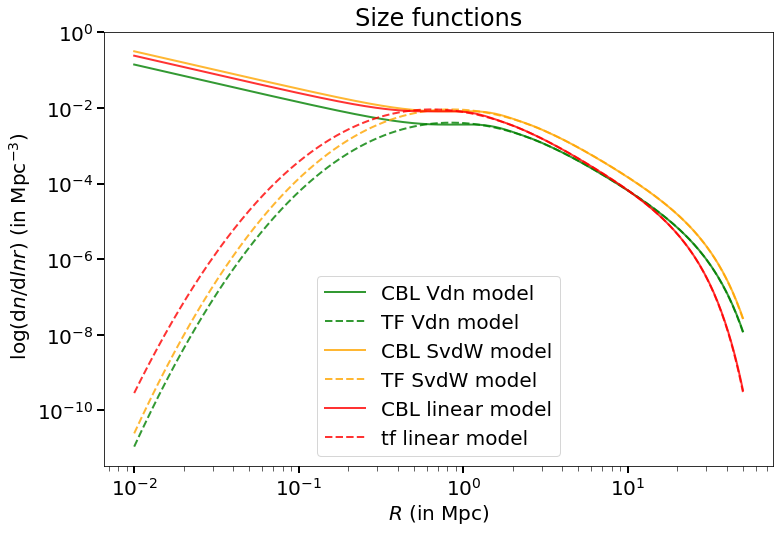

<Figure size 432x288 with 0 Axes>

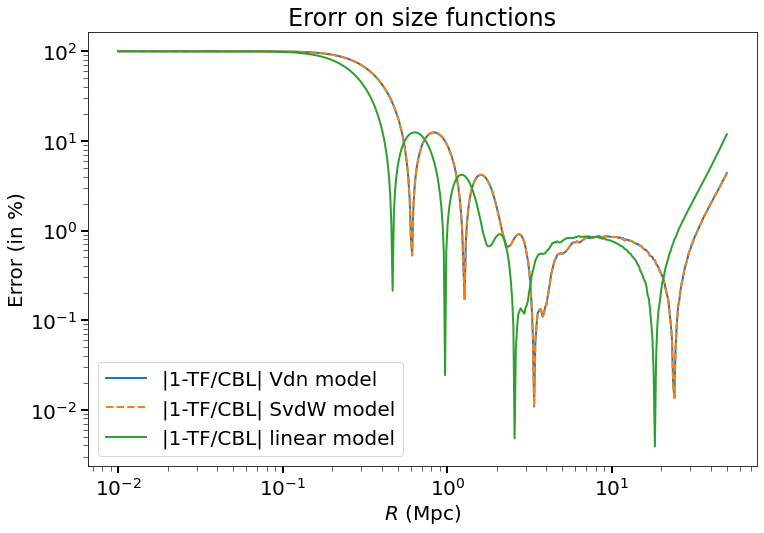

In [17]:
plt.figure(figsize=(12,8))
plt.plot(Rmpc, cbl_sf_Vdn, color='green', linewidth=2, ls='-', alpha=0.8, label = "CBL Vdn model")
plt.plot(Rmpc, tf_sf_Vdn, color='green', linewidth=2, ls='--', alpha=0.8, label = "TF Vdn model")
plt.plot(Rmpc, cbl_sf_SvdW, color='orange', linewidth=2, ls='-', alpha=0.8, label = "CBL SvdW model")
plt.plot(Rmpc, tf_sf_SvdW, color='orange', linewidth=2, ls='--', alpha=0.8, label = "TF SvdW model")
plt.plot(Rmpc, cbl_sf_lin, color='red', linewidth=2, ls='-', alpha=0.8, label = "CBL linear model")
plt.plot(Rmpc, tf_sf_lin, color='red', linewidth=2, ls='--', alpha=0.8, label = "tf linear model")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$R$ (in Mpc)")
plt.ylabel("$\ \log (\mathrm{d}n/\mathrm{d}ln{r})\\ \mathrm{(in~Mpc}^{-3}$)")
plt.legend()
plt.title("Size functions")

plt.figure()
plt.figure(figsize=(12,8))
plt.plot(Rmpc, np.abs(1 - tf_sf_Vdn/cbl_sf_Vdn)*100, label="|1-TF/CBL| Vdn model")
plt.plot(Rmpc, np.abs(1 - tf_sf_SvdW/cbl_sf_SvdW)*100, '--', label="|1-TF/CBL| SvdW model")
plt.plot(Rmpc, np.abs(1 - tf_sf_lin/cbl_sf_lin)*100, label="|1-TF/CBL| linear model")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.xlabel("$R$ (Mpc)")
plt.ylabel("Error (in %)")
plt.title("Erorr on size functions")